In [10]:
#!pip install pyclipper
#!pip install opencv-python

In [144]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread_collection, imsave, imshow, imread, imshow_collection
from skimage.feature import match_descriptors, ORB
from skimage.feature import corner_harris, corner_peaks, corner_fast, corner_subpix, corner_foerstner
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac
from imageio import mimread
from skimage.color import rgb2gray
import cv2
from skimage.feature import canny
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from skimage.measure import label as sk_label
from skimage.morphology import binary_opening, binary_closing
from skimage.filters import threshold_otsu, threshold_local, threshold_triangle
import pyclipper
import pandas as pd
from skimage.measure import regionprops

In [12]:
template_names = np.array(['pallete', 'shadow', 'coin', 'glasses', 'cat', 'pen', 'earing',
                           'scissors', 'frog', 'book'])

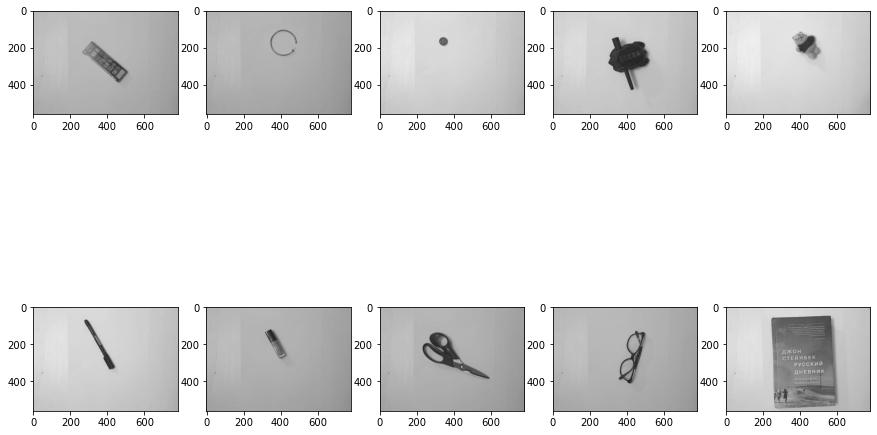

In [13]:
collection_p = 'images/patterns/*.jpg'
raw_templates = imread_collection(collection_p)
colored_templates = []
templates = []
for image in raw_templates:
    templates.append(rgb2gray(image))
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
height = [390, 950] #обрезаем так, чтобы размер фотографии был такой же, как у прямоугольников
width = [25, 805]
for i in range(10):
    templates[i] = templates[i][height[0]:height[1], width[0]:width[1]]
    ax[i % 2][i % 5].imshow(templates[i], cmap="gray")

Обрезали фотографии. Видно, что он все целиком влезают в окно.

Теперь выделим границы. По-хорошему, надо немного подкорректировать тень, но в принципе она не сильно мешает. 

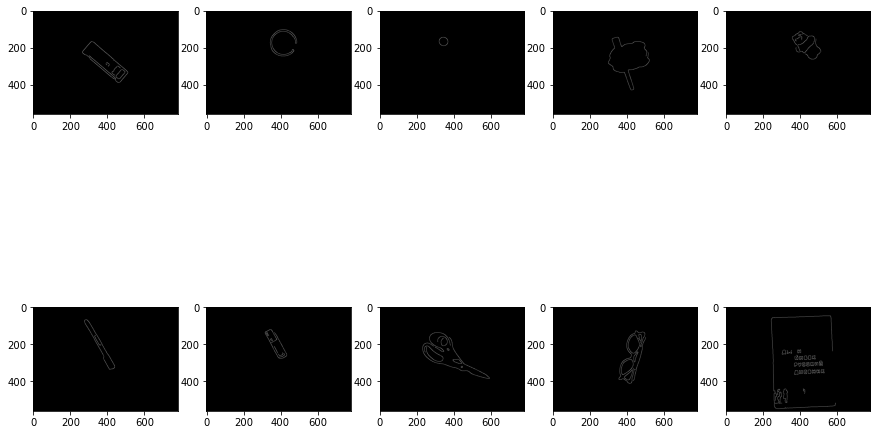

In [14]:
edges = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    edge = canny(templates[i], sigma=2.9)
    edges.append(np.stack(np.nonzero(edge), axis = 1))
    ax[i % 2][i % 5].imshow(edge, cmap="gray")
plt.savefig('edges.png', dpi=150)

Построим по границам выпуклые оболочки.
По картинкам видно, что они правда построились как надо. К сожалению, из-за разного раазмера предметов картинки слегка поехали, но вообще все в порядке.

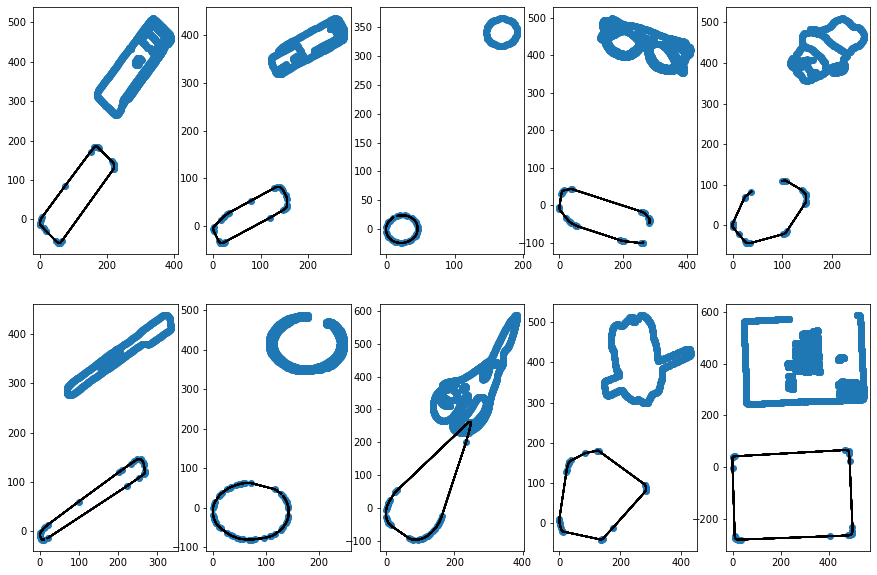

<Figure size 432x288 with 0 Axes>

In [15]:
template_hulls = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    points = edges[i]
    hull = ConvexHull(points)
    #Следующая строчка нужна, чтобы оболочки содержали начало координат. Это нужно для геометрической части
    points[hull.vertices] -= np.min(points[hull.vertices][:, 0]), points[np.argmin(points[hull.vertices][:, 0]), 1]
    template_hulls.append(points[hull.vertices])
    ax[i // 5][i % 5].plot(points[:,0], points[:,1], 'o')

    for simplex in hull.simplices:
    
        ax[i // 5][i % 5].plot(points[hull.vertices, 0], points[hull.vertices, 1], 'k-')

plt.show()
plt.savefig('convex-hulls.png', dpi=150)

In [16]:
collection_i = 'images/train/*.jpg'
raw_images = imread_collection(collection_i)
images = []

for image in raw_images:
    images.append(rgb2gray(image))

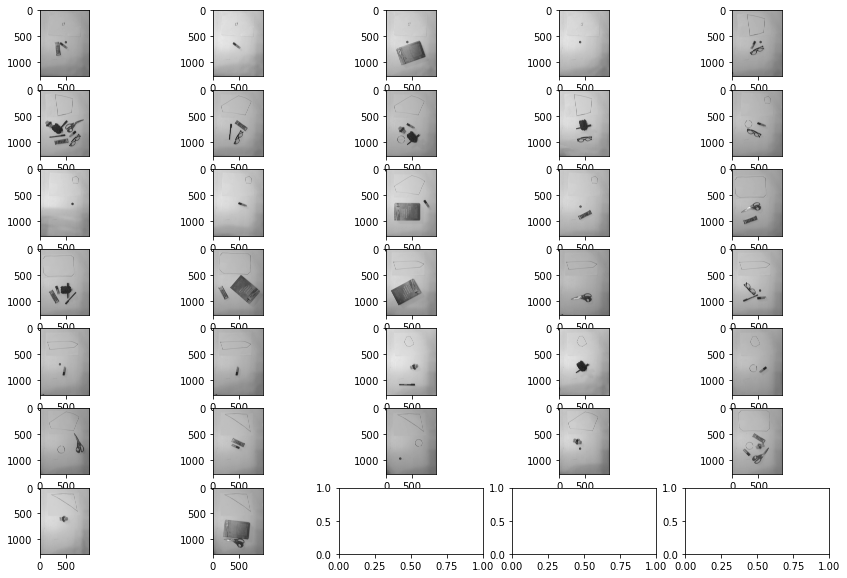

In [18]:

N = (len(images) + 4) // 5
fig, ax = plt.subplots(N, 5, figsize=(15, 10))
for i in range(len(images)):
    ax[i // 5][i % 5].imshow(images[i], cmap="gray")

Я попыталась еще попробовать на другом фоне, но, кажется, он слишком темный, дальше подробнее напишу.

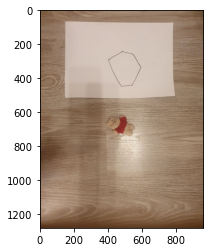

In [17]:
collection_i = 'images/dif_background/*.jpeg'
raw_dif_images = imread_collection(collection_i)
dif_images = []

for image in raw_dif_images:
    dif_images.append(rgb2gray(image))
plt.imshow(raw_dif_images[0])

Выделяем прямоугольники:

In [173]:
def get_polygons_and_objects(images):
    raw_polygons = []
    objects = []
    polygon_height = [0, 560]
    polygon_width = [0, 780]
    for i in range(len(images)):
        raw_polygons.append(images[i][polygon_height[0]:polygon_height[1], polygon_width[0]:polygon_width[1]])
        objects.append(images[i][560:1100, 50:850])
    return raw_polygons, objects

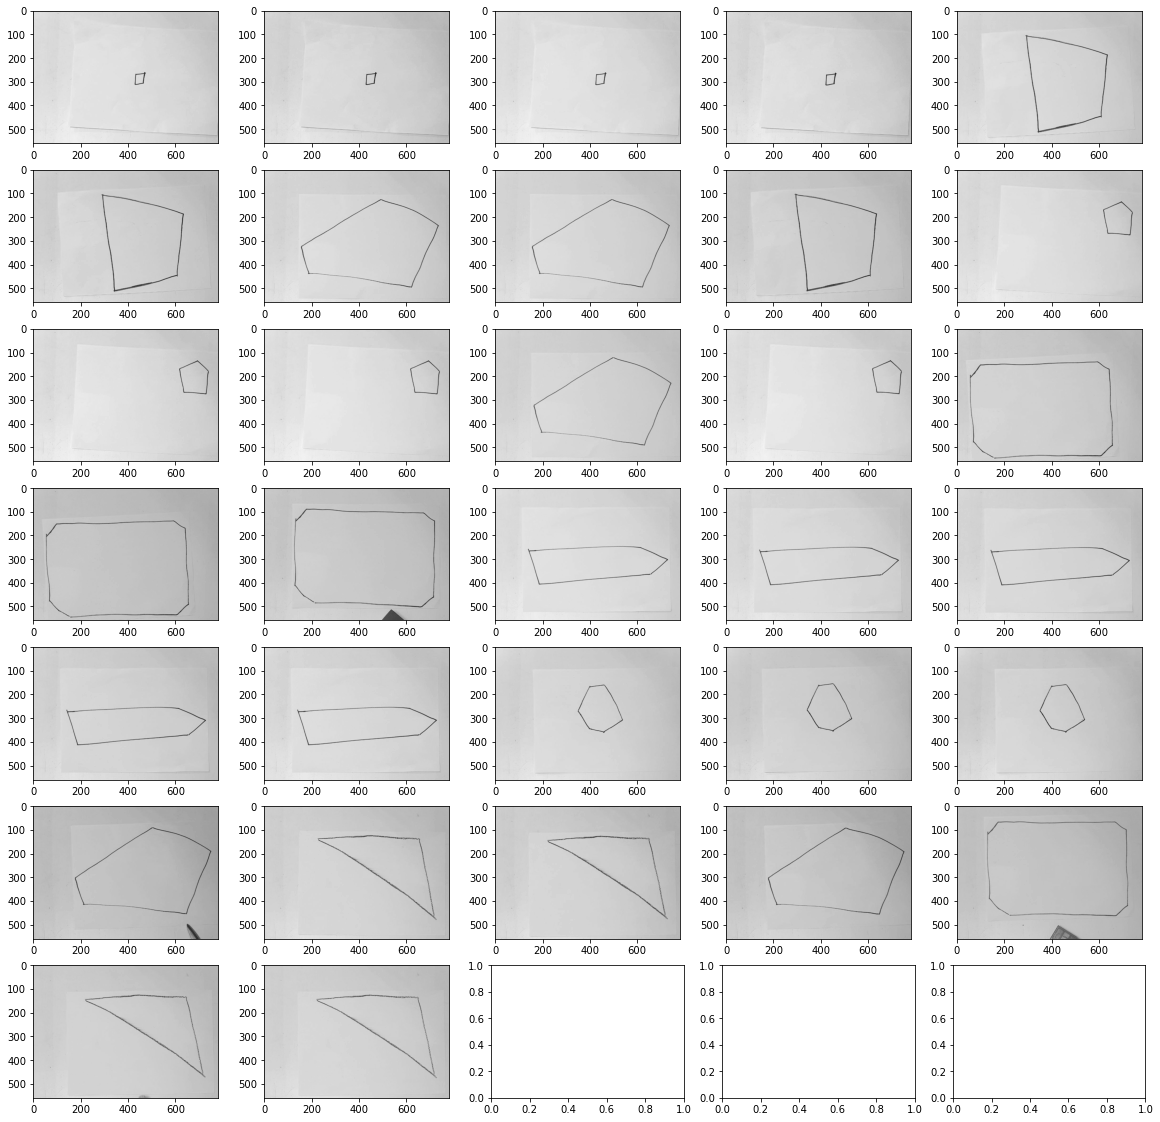

In [174]:
N = (len(images) + 4) // 5
raw_polygons, objects = get_polygons_and_objects(images)
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
for i in range(len(images)):
    ax[i // 5][i % 5].imshow(raw_polygons[i], cmap="gray")

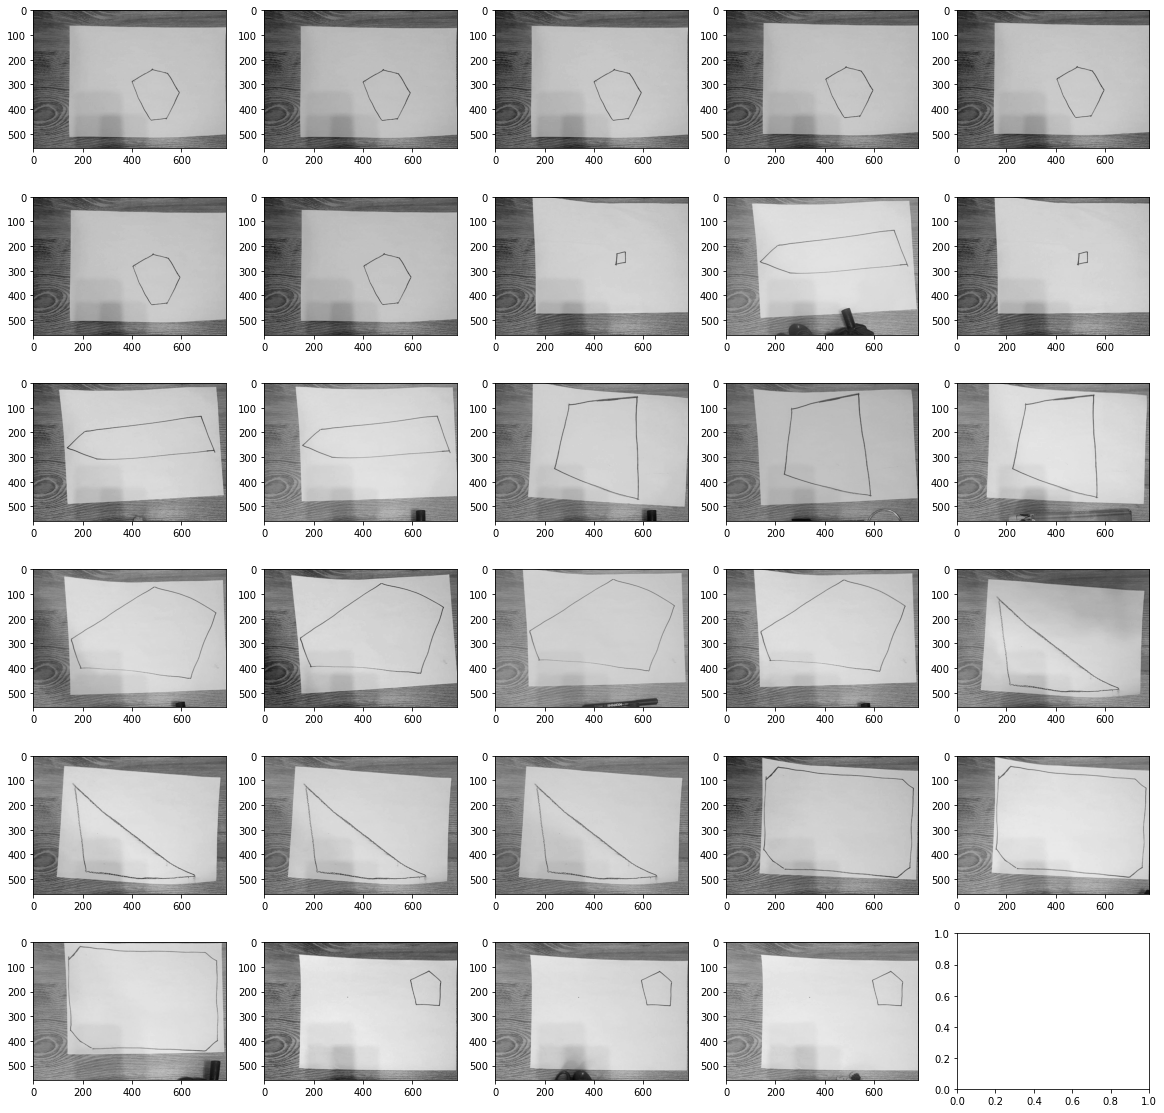

In [269]:
raw_dif_polygons, dif_objects = get_polygons_and_objects(dif_images)
fig, ax = plt.subplots(N - 1, 5, figsize=(20, 20))
for i in range(len(dif_images)):
    ax[i // 5][i % 5].imshow(raw_dif_polygons[i], cmap="gray")

Выделяем прямоугольники на фотографиях. Работает и на старом фоне, и на новом:

In [176]:
def get_polygons(raw_polygons):
    polygons = []
    for i in range(len(raw_polygons)):
        #binary_opening нужен, потому что на таком фоне слишком хорошо выделяются границы листа бумаги
        edge = binary_opening(binary_closing(canny(raw_polygons[i], sigma = 2.5), np.ones((7, 7))), np.ones((2, 2)))
        labels, num = sk_label(edge, return_num = True)
        #выделяем наибольшую по площалли компоненту, иначе много мусора
        props = regionprops(labels)
        areas = [prop.area for prop in props]
        largest_comp_id = np.array(areas).argmax()
        polygons.append(np.stack(np.nonzero(np.where(labels == largest_comp_id + 1,edge, 0)), axis = 1))
    return polygons

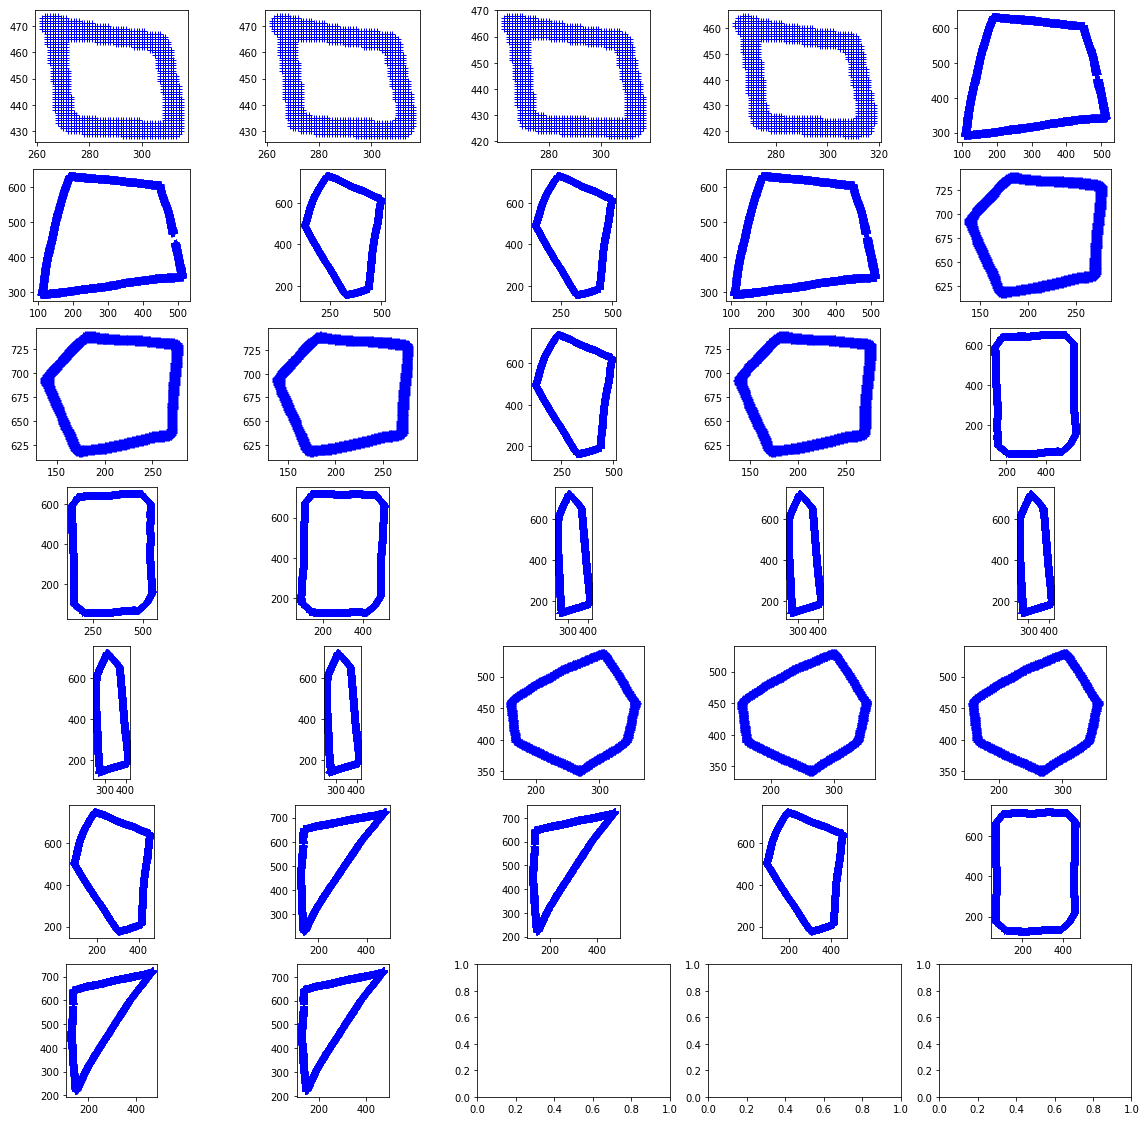

In [188]:
polygons = get_polygons(raw_polygons)
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
for i in range(len(polygons)):
    ax[i // 5][i % 5].set_aspect('equal', adjustable='box')
    ax[i // 5][i % 5].plot(polygons[i][:, 0], polygons[i][:, 1], '+b', lw=2)

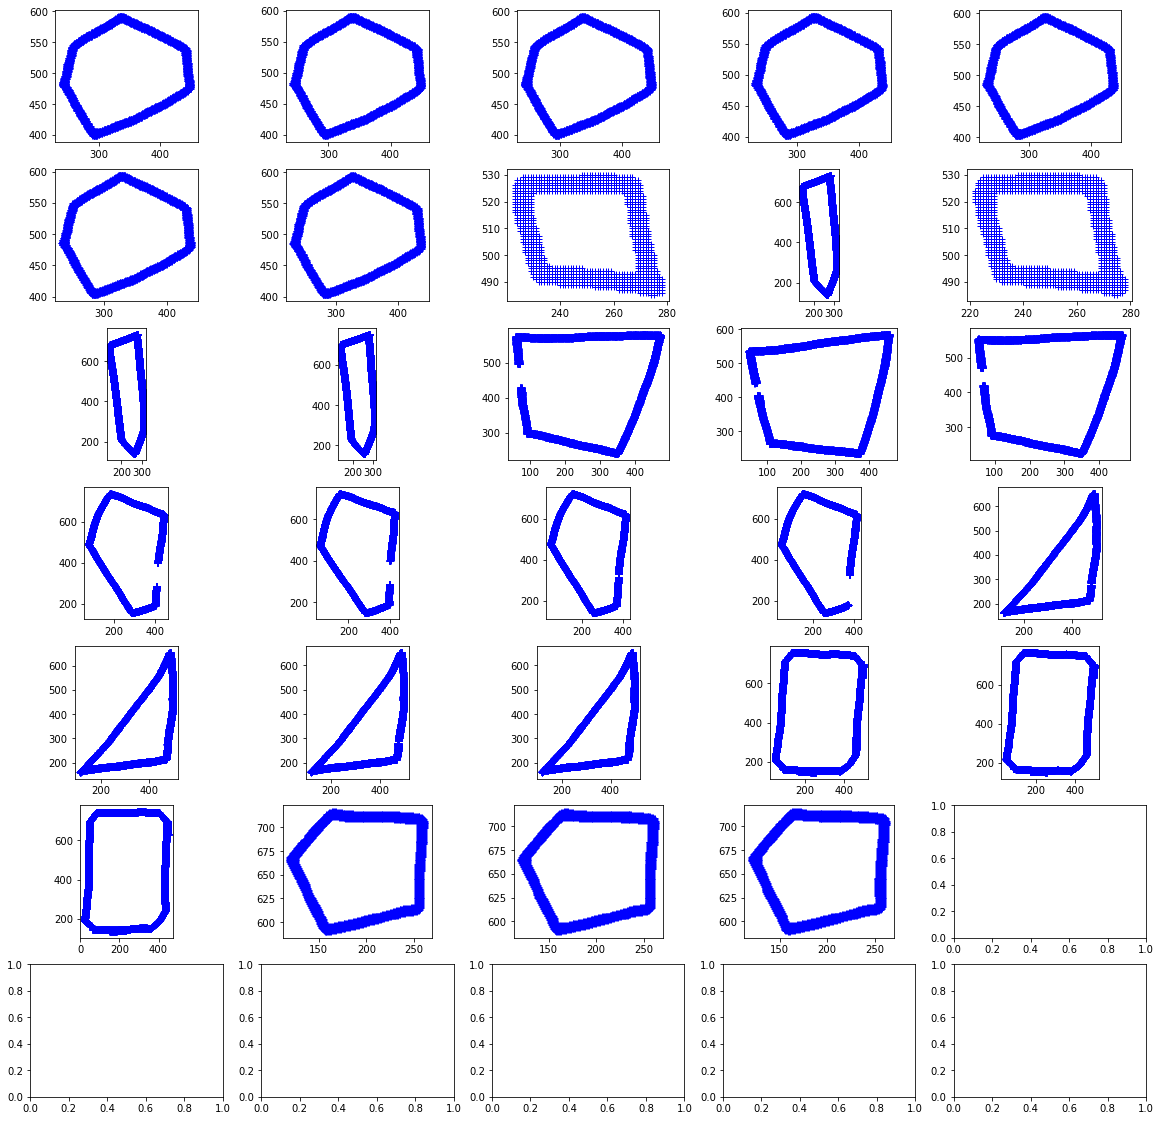

In [187]:
dif_polygons = get_polygons(raw_dif_polygons)
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
for i in range(len(dif_polygons)):
    ax[i // 5][i % 5].set_aspect('equal', adjustable='box')
    ax[i // 5][i % 5].plot(dif_polygons[i][:, 0], dif_polygons[i][:, 1], '+b', lw=2)

Упрощаем прямоугольники: 

In [151]:
def get_polygon_hulls(polygons):
    polygon_hulls = []
    for i in range(len(polygons)):
        points = polygons[i]
        hull = ConvexHull(points)
        new_polygon = np.array(pyclipper.CleanPolygon(points[hull.vertices]))
        polygon_hulls.append(new_polygon)
    return polygon_hulls


In [189]:
polygon_hulls = get_polygon_hulls(polygons)
dif_polygon_hulls = get_polygon_hulls(dif_polygons)

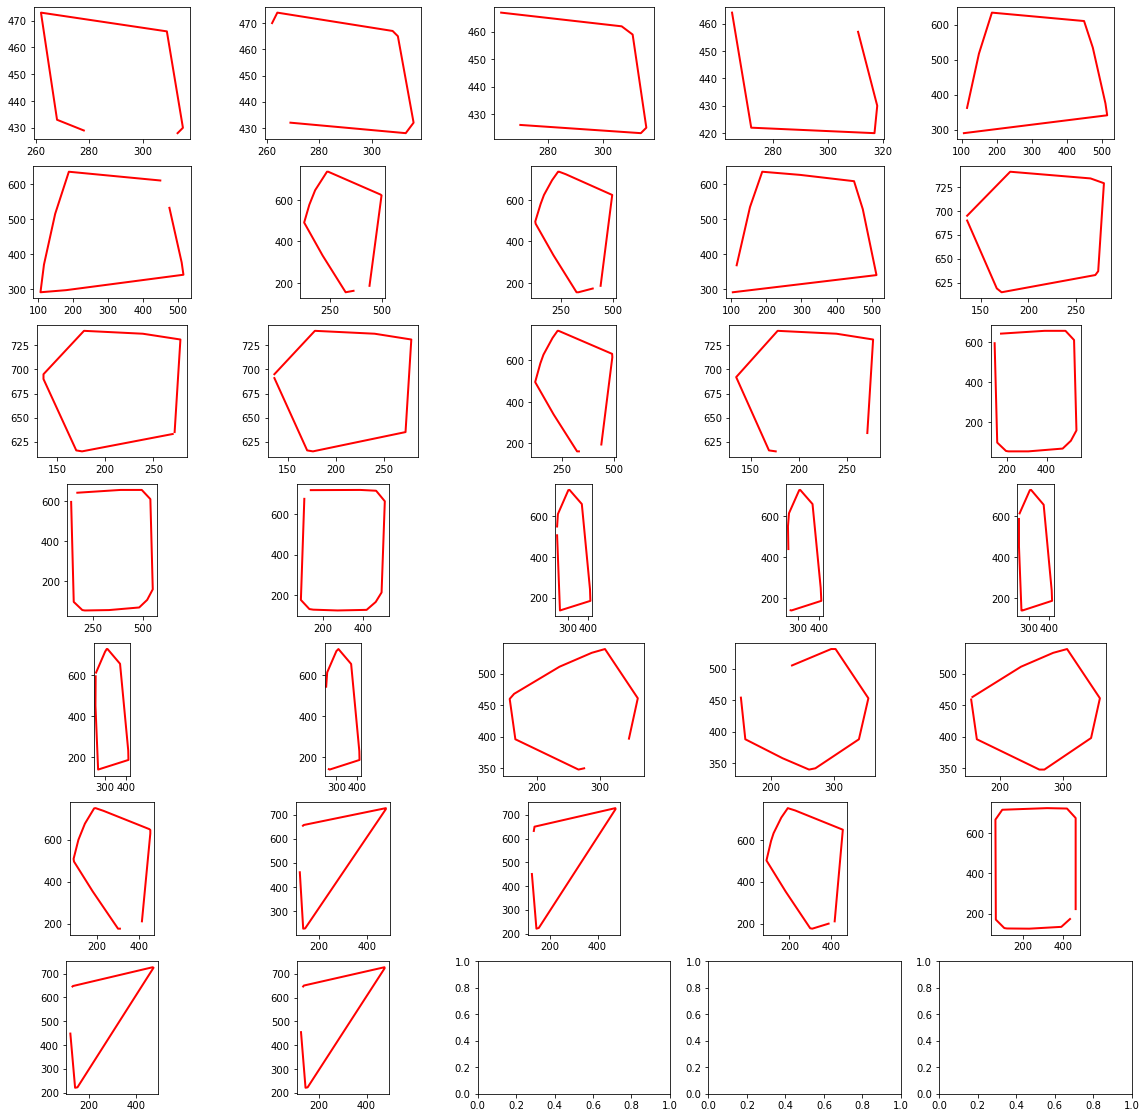

In [191]:
fig, ax = plt.subplots(N, 5, figsize=(20, 20))
for i in range(len(polygon_hulls)):
    ax[i // 5][i % 5].set_aspect('equal', adjustable='box')
    ax[i // 5][i % 5].plot(polygon_hulls[i][:, 0], polygon_hulls[i][:, 1], '-r', lw=2)

Выделение дескрипторов шаблонов:

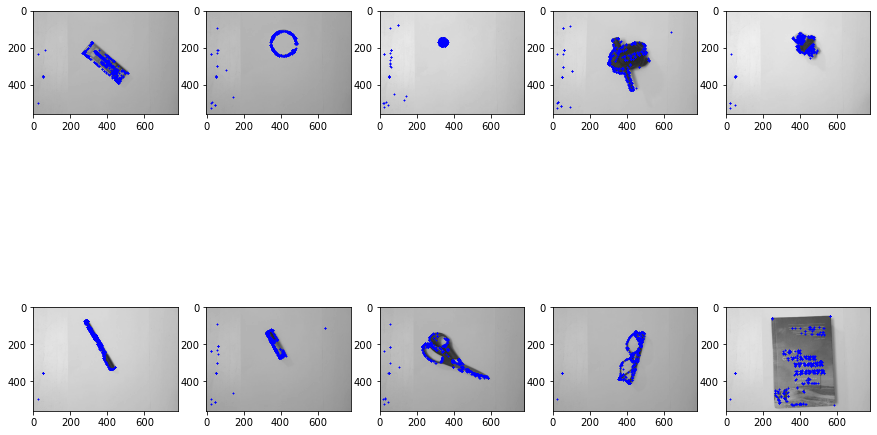

In [23]:
template_descriptors = []
template_keypoints = []
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
for i in range(10):
    orb = ORB(harris_k = 0.001)
    orb.detect_and_extract(templates[i])
    descriptor = orb.descriptors
    template_descriptors.append(descriptor)
    template_keypoints.append(orb.keypoints)
    ax[i % 2][i % 5].imshow(templates[i], cmap="gray")
    ax[i % 2][i % 5].plot(orb.keypoints[:, 1], orb.keypoints[:, 0], '+b', markersize=2)

Тут я попыталась выделеть границы у предметов на новом фоне, кое-как они выделяются и даже более-менее неплохо:

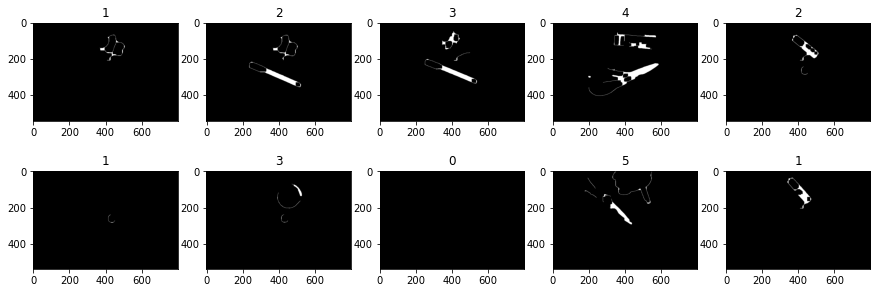

In [384]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
dif_binary_objects = []
dif_nums = []
for i in range(10):
    edge = binary_closing(canny(dif_objects[i], sigma = 3), np.ones((15, 15)))
    dif_binary_objects.append(edge)
    labels, num = sk_label(edge, return_num = True)
    dif_nums.append(num) #количество компонент связности, т.е предметов(с книгой не очень работает)
    ax[i // 5][i % 5].set_title(num)
    ax[i // 5][i % 5].imshow(edge, cmap="gray")

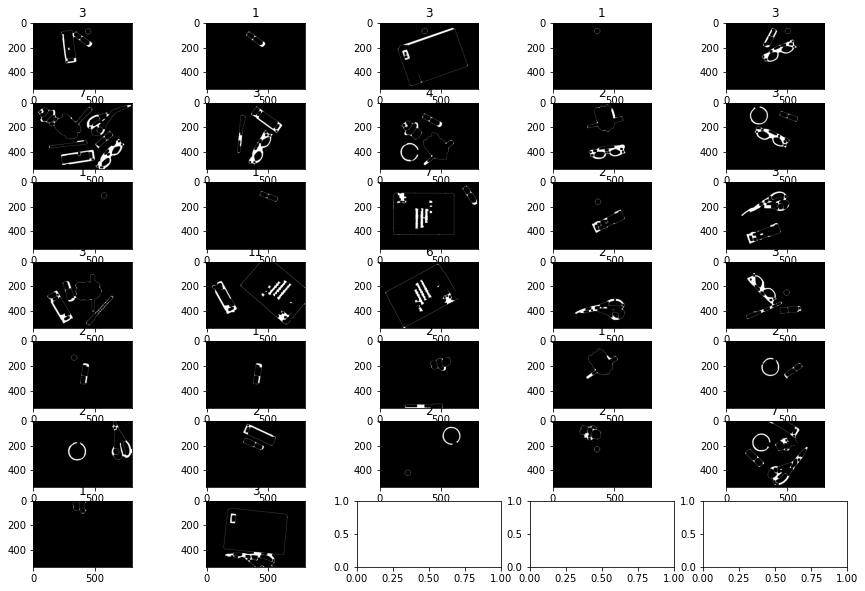

In [202]:
fig, ax = plt.subplots(N, 5, figsize=(15, 10))
binary_objects = []
nums = []
for i in range(len(objects)):
    edge = binary_closing(canny(objects[i], sigma = 3), np.ones((15, 15)))
    labels, num = sk_label(edge, return_num = True)
    binary_objects.append(labels)
    nums.append(num) #количество компонент связности, т.е предметов(с книгой не очень работает)
    ax[i // 5][i % 5].set_title(num)
    ax[i // 5][i % 5].imshow(edge, cmap="gray")

Найдем предметы на картинке. Функция detect_objects ищет для картинки количество соответствий особых точек с каждым шаблоном. Потом этот массив сортируется по убыванию количества соответствий. Функция возвращает k первых предметов, где k --- количество компонент связности на картинке. Работает это очень не точно, но первый предмет обычно находится правильно. Для фотографий с книгой не работает, потому что она разбивается на несколько компонент связности из-за текста.

In [203]:

def detect_objects(image, num_of_obj):
    a = [[0, i] for i in range(10)]
    for i in range(10):
        orb = ORB()
        orb.detect_and_extract(image)
        descriptor = orb.descriptors
        matches = match_descriptors(template_descriptors[i], descriptor, cross_check = True)
        src = template_keypoints[i][matches[:, 0]]
        dst = orb.keypoints[matches[:, 1]]
        estimated_transform, inliers = ransac((src, dst), AffineTransform, min_samples=3,
                                   residual_threshold=2, max_trials=1000)
        a[i][0] += np.where(inliers == True, 1, 0).sum()
    a.sort(key=lambda x: x[0])
    a.reverse()
    return np.array(a)[:num_of_obj, 1]

In [204]:
detected_objects = []
for i in range(32):
    detected_objects.append(detect_objects(objects[i], nums[i]))

In [219]:
dif_detected_objects = []
for i in range(len(dif_objects)):
    dif_detected_objects.append(detect_objects(adjust_sigmoid(dif_objects[i]), dif_nums[i]))
    

Посмотрим, как оно работает. Работает не очень, но что-то определяет:

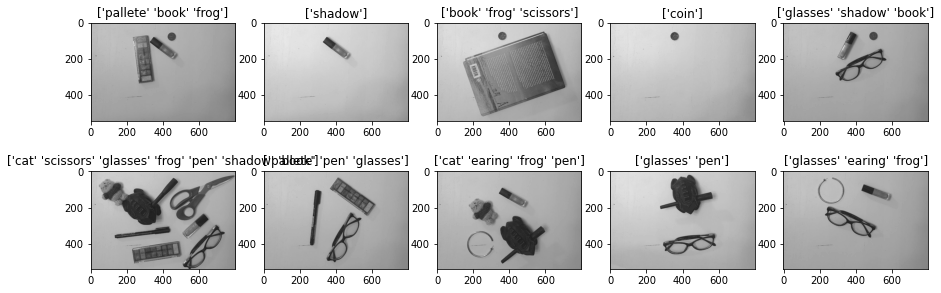

In [207]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(10):
    ax[i // 5][i % 5].set_title(str(template_names[detected_objects[i]]))
    ax[i // 5][i % 5].imshow(objects[i], cmap="gray")

Но вот тут уже на новом фоне видно, что определяются предметы довольно плохо (поэтому я даже не стала продолжать со следующим алгоритмом):

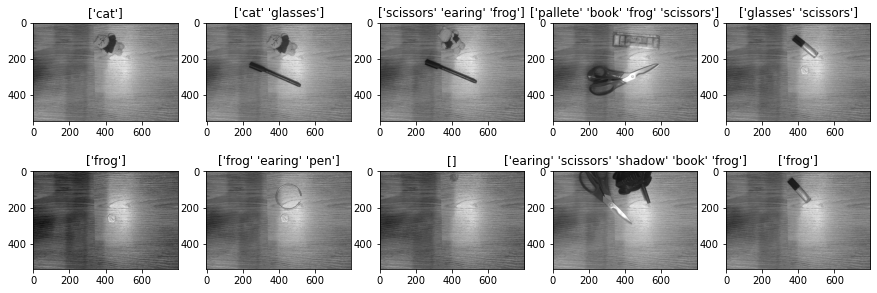

In [221]:
fig, ax = plt.subplots(2, 5, figsize=(15, 5))
for i in range(10):
    ax[i // 5][i % 5].set_title(str(template_names[dif_detected_objects[i]]))
    ax[i // 5][i % 5].imshow(dif_objects[i], cmap="gray")

Функкция, которая поворачивает многоугольник:

In [313]:
def rotate(polygon, angle = (np.pi / 4), center = np.array([0, 0])):
    return np.dot(polygon-center, np.array([[np.cos(angle),np.sin(angle)],[-np.sin(angle),np.cos(angle)]]))

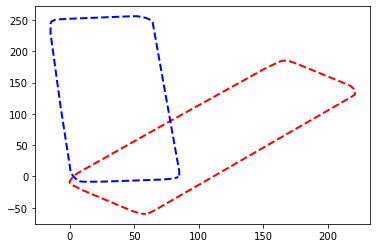

In [385]:
new = rotate(template_hulls[0])
plt.plot(template_hulls[0][:, 0], template_hulls[0][:, 1], 'r--', lw=2)
plt.plot(new[:, 0], new[:, 1], 'b--', lw=2)

По идее функция работает так:
    Берется разница минковского многоугольника и шаблона, из нее вычитается (как множество) многоугольник. 
    Если получившееся множество пустое -- ответ нет
    Иначе: "перемещаем" шаблон так, чтобы его самая левая точка совпадала с самой левой точкой получившегося множества. Вычитаем перемещенный шаблон из многоугольника (как множество), получаем (кажется?) многоугольник без дырок посередине. Выполняем первый шаг для следующего шаблона и нового многоугольника.
    

Вот тут произошло что-то непонятное. Я собиралась сделать код, который работал бы как предыдущая версия, но при этом поворачивал бы шаблоны на какое-то количество градусов. При повороте на pi\8 было какое-то улучшение, но потом я решила проверить, работает ли это так же без поворота. Так вот, почему-то новая версия работает существенно лучше предыдущей (но кажется это случайность).

In [437]:
def can_fit(polygon, detected_objects, show=False):
    n = len(detected_objects)
    if n == 0:
        return 1    
    if show:     
        fig, ax = plt.subplots(figsize=(20, 20), squeeze=False)
        ax = [[] for i in range(8)]
    res = 1   
    j = detected_objects[0]
    for t in range(1):
        template = rotate(template_hulls[j], (2 * np.pi / 2) * t)
        if show:
            

            ax[t]= plt.subplot2grid((1, n), (0, t))
            ax[t].set_title(template_names[j])
            ax[t].set_aspect('equal', adjustable='box')
            ax[t].plot(polygon[:, 0], polygon[:, 1], 'r--', lw=2, label='polygon')
            ax[t].plot(template_hulls[j][:, 0], template_hulls[j][:, 1], 'g--', lw=1, label='template')
        mink_diff = pyclipper.MinkowskiDiff(template, polygon)
        c = pyclipper.Pyclipper()
        if len(mink_diff) == 1:
            c.AddPath(mink_diff[0], pyclipper.PT_CLIP, True)
            
        else:
            c.AddPaths(mink_diff, pyclipper.PT_CLIP, True)
        c.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        solution = c.Execute(pyclipper.CT_DIFFERENCE)
        #избавляемся от артефактов (хотя можем случайно и нормальные точки пропустить)
        k = 0
        while k < (len(solution)):
            if pyclipper.Area(solution[k]) / pyclipper.Area(polygon) < 0.1:
                solution.pop(k)
            k += 1
        if len(solution) == 0:
            res = 0
            continue
        if show:
            for p in solution:
                ax[t].plot(np.array(p)[:, 0], np.array(p)[:, 1], 'y--', lw=2, label='allowed area')
            
        x = np.array(solution[0])
        #-1  нужно, чтобы многоугольник точно оставался простым и не образовывалось "дырки" внутри
        point = np.min(x[:, 0]) - 1, x[np.argmin(x[:, 0])][1] - 1
        hole = template_hulls[j] + point
        if show:
            line2, =ax[t].plot(hole[:, 0], hole[:, 1], 'b--', lw=2, label='hole')
            ax[t].legend()
        c = pyclipper.Pyclipper()
        c.AddPath(hole, pyclipper.PT_CLIP, True)
        c.AddPath(polygon, pyclipper.PT_SUBJECT, True)
        polygon = np.array(pyclipper.CleanPolygon(c.Execute(pyclipper.CT_DIFFERENCE)[0]))
        res = max(can_fit(polygon, detected_objects[1:], show), res)
        #ax[i].legend(handles=[line1], loc='upper right')

        # Add the legend manually to the current Axes.
        #ax[i].gca().add_artist(first_legend)

        # Create another legend for the second line.
        #ax[i].legend(handles=[line2], loc='lower right')
        
              
    return res
         
        
        
        

In [438]:
answers = []
for i in range(len(detected_objects)):
    answers.append(can_fit(polygon_hulls[i], detected_objects[i]))#sorted(detected_objects[i], key=lambda x: pyclipper.Area(template_hulls[x]))[::-1]))
answers

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0]

Проверим процент правильных ответов. Получили 0.65, лучше, чем случайно или всегда да (выборка почти сбалансированная, 17 да, 15 нет). Можно, конечно, и лучше.

In [440]:
df = pd.read_csv('images.csv')
value = df.iloc[:, 1].to_numpy()
np.sum(np.array(answers) == value) / 32

0.84375

In [441]:
Но при этом появились ложноположительные результаты, что не очень хорошо:

SyntaxError: invalid syntax (<ipython-input-441-8b225457204d>, line 1)

In [439]:
df.join(pd.DataFrame(np.array(answers), columns=['answer']))

,url,value,answer
0,images/photo5321203346188646647.jpg,0,0
1,images/photo5321203346188646648.jpg,0,0
2,images/photo5321203346188646649.jpg,0,0
3,images/photo5321203346188646650.jpg,0,0
4,images/photo5321203346188646651.jpg,1,1
5,images/photo5321203346188646652.jpg,0,1
6,images/photo5321203346188646653.jpg,1,1
7,images/photo5321203346188646654.jpg,1,1
8,images/photo5321203346188646655.jpg,1,1
9,images/photo5321203346188646656.jpg,0,0


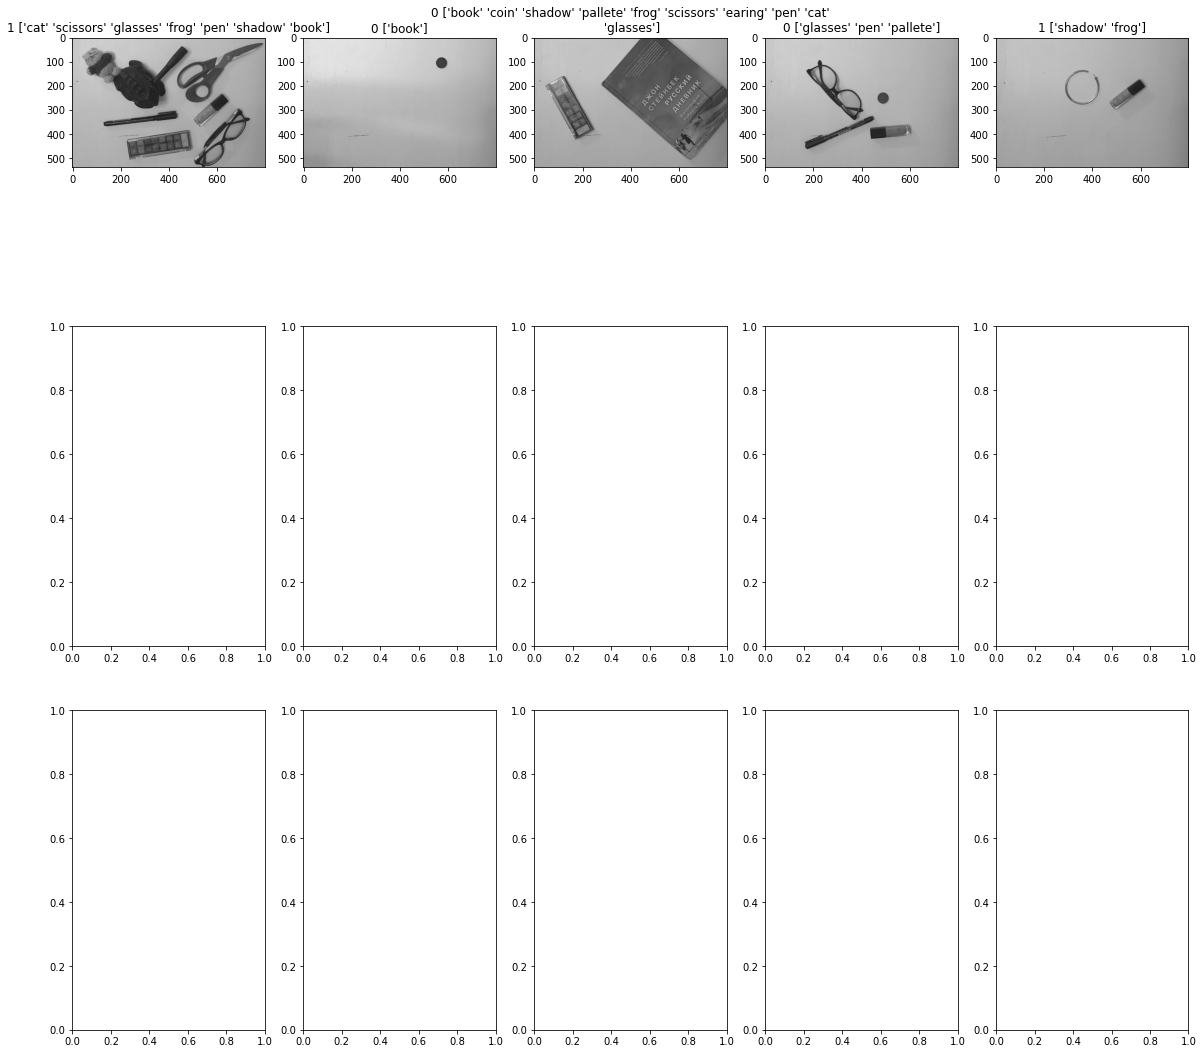

In [444]:
fig, ax = plt.subplots(3, 5, figsize=(20, 20))
j = 0
for i in range(32):
    if answers[i] != df.iloc[:, 1][i]:
        ax[j // 5][j % 5].imshow(objects[i], cmap='gray')
        ax[j // 5][j % 5].set_title(str(answers[i]) + ' ' + str(template_names[detected_objects[i]]))
        j += 1